# Unidad 2. Medidas en grafos
Camino mínimos, camino al azar, centralidad, importancia de nodos y aristas.
Modularidad. Grafos al azar. Ejercitación: Cálculo de caminos mínimos para distintos modelos de grafos aleatorios.

Algunos links de interés:
- [Número de Erdos](https://en.wikipedia.org/wiki/Erd%C5%91s_number)
- [Seis grados de separación de Kevin Bacon](https://en.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon)
- [Número de Erdos-Bacon](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93Bacon_number)
- [Oracle of Bacon](https://oracleofbacon.org/how.php)
- [Breadth-firsth search](https://en.wikipedia.org/wiki/Breadth-first_search)
- [Dataset de IMDb en Kaggle](https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset) - con esta data se han hecho los grafos que siguen.

In [1]:
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
import seaborn as sns
# CAMBIEN LA SIGUIENTE LÍNEA A LA RAÍZ DEL REPOSITORIO EN SU PC
os.chdir("/home/gonzalo/maestria/aag/")

In [2]:
roles = pd.read_csv("data/archive/IMDb title_principals.csv")
actores = pd.read_csv("data/archive/IMDb names.csv")#, nrows=10000)
actores[["id", "nombre"]] = actores[["imdb_name_id", "name"]]
actores["part"] = "actores"
actores["arg"] = actores.place_of_birth.notna() & actores.place_of_birth.str.endswith("Argentina")

In [3]:
actores[actores.arg].head(2)

,imdb_name_id,name,birth_name,height,bio,birth_details,date_of_birth,place_of_birth,death_details,date_of_death,...,reason_of_death,spouses_string,spouses,divorces,spouses_with_children,children,id,nombre,part,arg
1350,nm0001377,Olivia Hussey,Olivia Osuna,157.0,"At age 15, when most young women are nurturing...","April 17, 1951 in Buenos Aires, Federal Distri...",1951-04-17,"Buenos Aires, Federal District, Argentina",NaN,NaN,...,NaN,David Glen Eisley (1991 - present) (1 child)\...,3,2,3,3,nm0001377,Olivia Hussey,actores,True
1868,nm0001903,Norma Aleandro,Norma Aleandro Robledo,NaN,Norma Aleandro is the Grande Dame of Argentine...,"May 2, 1936 in Buenos Aires, Federal District,...",1936-05-02,"Buenos Aires, Federal District, Argentina",NaN,NaN,...,NaN,Eduardo Le Poole (? - present)\nOscar Ferrign...,2,1,1,1,nm0001903,Norma Aleandro,actores,True


In [4]:
films = pd.read_csv("data/archive/IMDb movies.csv")#, nrows=10000)
films[["id", "nombre"]] = films[["imdb_title_id", "original_title"]]
films["part"] = "films"
films["arg"] = films.country == "Argentina"

/home/gonzalo/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
roles.shape, actores.shape, films.shape

((835513, 6), (297705, 21), (85855, 26))

In [6]:
g = nx.from_pandas_edgelist(roles, "imdb_title_id", "imdb_name_id", edge_attr=True)

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

In [7]:
node_attrs = ["id", "nombre", "arg", "part"]
nx.set_node_attributes(g, actores[node_attrs].set_index("id").to_dict("index"))
nx.set_node_attributes(g, films[node_attrs].set_index("id").to_dict("index"))

In [8]:
# el subgrafo del cine argentino
sg = nx.subgraph(g, [node for node, es_argentine in g.nodes(data="arg") if es_argentine])

In [9]:
colaboraciones = nx.bipartite.project(sg, [n for n, part in sg.nodes(data="part") if part == "actores"])
carreras = nx.bipartite.project(sg, [n for n, part in sg.nodes(data="part") if part == "films"])

In [10]:
len(colaboraciones.nodes), len(colaboraciones.edges)

(1046, 2483)

In [11]:
def distribucion_grado(g):
    grados = pd.Series(dict(g.degree()))
    return grados.value_counts()

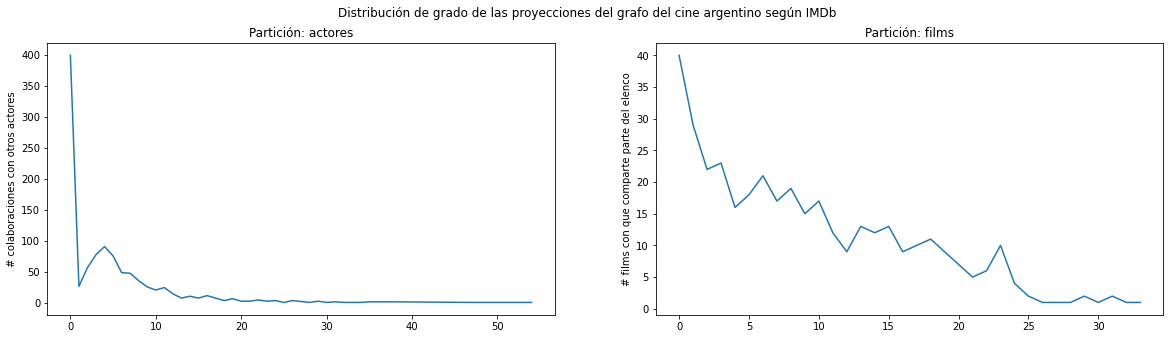

In [12]:
plt.subplots(1, 2, figsize=(20, 5))
plt.subplot(121)
dg = distribucion_grado(colaboraciones)
sns.lineplot(x=dg.index, y=dg.values)
plt.ylabel("# colaboraciones con otros actores")
plt.title("Partición: actores")
plt.subplot(122)
dg = distribucion_grado(carreras)
sns.lineplot(x=dg.index, y=dg.values)
plt.ylabel("# films con que comparte parte del elenco")
plt.title("Partición: films")
plt.suptitle("Distribución de grado de las proyecciones del grafo del cine argentino según IMDb")
plt.show()

In [13]:
DARIN = "nm0201857"
BACON = "nm0000102"

LAMOTHE = "nm1394133"
STREEP = "nm0000658"

MIRANDA_JULY = "nm0432380"
NORMA_ALEANDRO = "nm0001903"

SUSANA_GIMENEZ = "nm0319880"
JACK_NICHOLSON = "nm0000197"

In [16]:
source, target = LAMOTHE, DARIN

In [17]:
[colaboraciones.nodes[x]["nombre"] for x in nx.shortest_path(colaboraciones, source, target)]

['Esteban Lamothe', 'Axel Kuschevatzky', 'Claudia Fontán', 'Ricardo Darín']

Las rutas más cortas conectando dos nodos en el cine argentino y en el cine mundial, no tienen por qué ser igual de largas:

In [18]:
[sg.nodes[x]["nombre"] for x in nx.shortest_path(sg, source, target)]

['Esteban Lamothe',
 'Abzurdah',
 'Axel Kuschevatzky',
 'La reconstrucción',
 'Claudia Fontán',
 'El amor menos pensado',
 'Ricardo Darín']

Ni siguiera similares:

In [19]:
[g.nodes[x]["nombre"] for x in nx.shortest_path(g, source, target)]

['Esteban Lamothe', 'La patota', 'Dolores Fonzi', 'El aura', 'Ricardo Darín']

In [20]:
[n for n, deg in sg.degree() if deg > 10]

['nm0647412', 'nm0944158', 'nm0289856', 'nm0228338', 'nm0691672']

In [21]:
# Por comodidad, renombramos los nodos con sus nombres "comunes".
colab = colaboraciones = nx.relabel_nodes(colaboraciones, actores[actores.arg].set_index("id").nombre.to_dict())

In [22]:
centralidades = pd.DataFrame(
    {
        "grado": dict(colab.degree()),  # También exsite nx.degree_centrality que lo expersa como proporción de los nodos totales.
        "cercania": nx.closeness_centrality(colab),
        "betweenness": nx.betweenness_centrality(colab),
        "eigen": nx.eigenvector_centrality(colab),
        "pagerank":  nx.algorithms.pagerank(colab),
    }
)

In [23]:
nx.set_node_attributes(colab, centralidades.to_dict("index"))

<AxesSubplot:xlabel='grado', ylabel='index'>

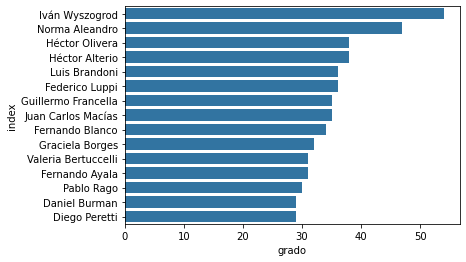

In [24]:
# CAMBIE EL `criterio` PARA CAMBIAR EL GRÁFICO
criterio = "grado"
sns.barplot(y="index", x=criterio, color="C0", data=centralidades.reset_index().sort_values(criterio, ascending=False).head(15))

<Figure size 1440x1440 with 0 Axes>

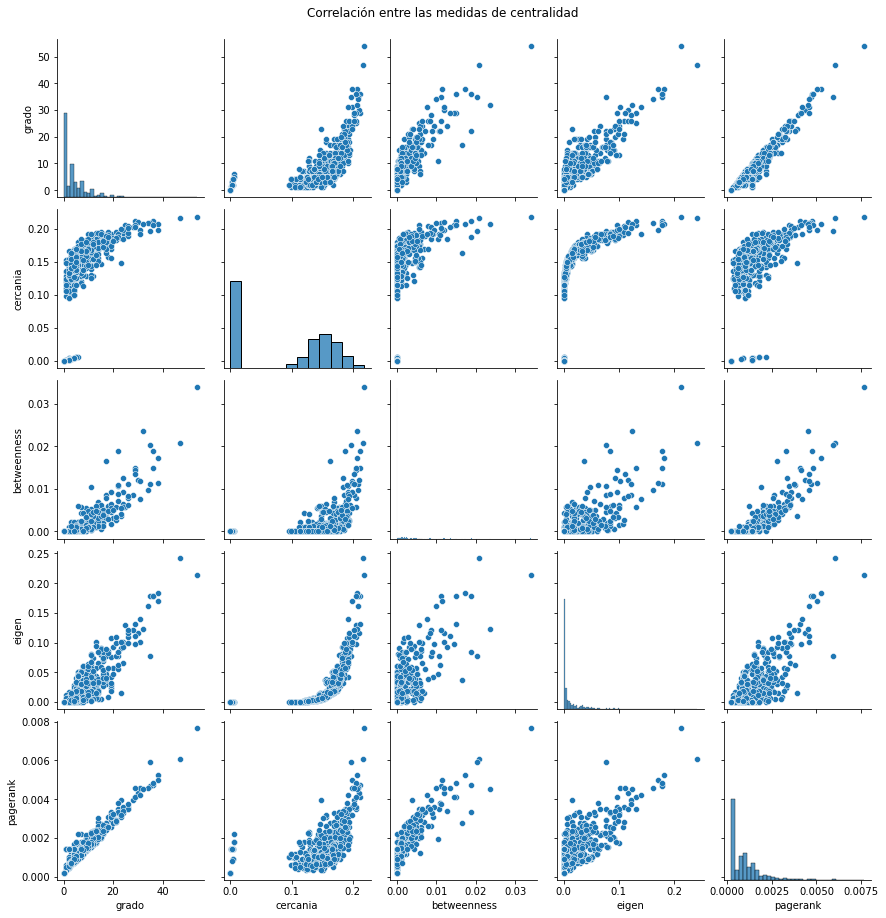

In [25]:
plt.figure(figsize=(20, 20))
sns.pairplot(centralidades)
plt.suptitle("Correlación entre las medidas de centralidad", y=1.02)
plt.show()

¿Coinciden las centralidades calculadas por networkx con las que uno calcularía a mano?

In [26]:
# Tomemos la cercanía de Norma Aleandro:
(len(colab.nodes) - 1) / pd.Series(nx.shortest_paths.single_source_dijkstra_path_length(colab, "Norma Aleandro")).sum()

0.6498756218905473

In [27]:
nx.closeness_centrality(colab)["Norma Aleandro"]

0.2163875598086124

Qué raro... ¿Y si probamos con un grafo más simple?

In [28]:
g = nx.karate_club_graph()

In [29]:
(len(g.nodes) - 1) / pd.Series(nx.shortest_paths.single_source_dijkstra_path_length(g, 0)).sum()

0.5689655172413793

In [30]:
nx.closeness_centrality(g)[0]

0.5689655172413793

¡Parece andar! ¿Se les ocurre por dónde puede venir la diferencia?

In [31]:
# Hay a lo sumo 10 actores por pelicula, así uqe el bacon numbr que calculamos es a lo sumo el del oracle que tiene todos los actores
roles.groupby("imdb_title_id").apply(len).describe()

count    85848.000000
mean         9.732469
std          0.790777
min          1.000000
25%         10.000000
50%         10.000000
75%         10.000000
max         10.000000
dtype: float64

In [32]:
# Buscar fils o actores por nombre parcial
# films[films.title.str.contains("Summit")]
actores[actores.name.str.contains("Norma Aleandro")]

,imdb_name_id,name,birth_name,height,bio,birth_details,date_of_birth,place_of_birth,death_details,date_of_death,...,reason_of_death,spouses_string,spouses,divorces,spouses_with_children,children,id,nombre,part,arg
1868,nm0001903,Norma Aleandro,Norma Aleandro Robledo,NaN,Norma Aleandro is the Grande Dame of Argentine...,"May 2, 1936 in Buenos Aires, Federal District,...",1936-05-02,"Buenos Aires, Federal District, Argentina",NaN,NaN,...,NaN,Eduardo Le Poole (? - present)\nOscar Ferrign...,2,1,1,1,nm0001903,Norma Aleandro,actores,True
